# Lab | Making predictions with logistic regression

In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


1) Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).
2) Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [2]:
# get the data from Sakila
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)


In [3]:
# getting the data

query = '''
SELECT f.title,
	f.rental_rate,
    f.length,
    f.rating,
    fc.category_id,
    f.replacement_cost, 
CASE
WHEN MONTH(r.rental_date) = 5 AND YEAR(r.rental_date) = 2005 THEN 1
ELSE 0
END AS rented_in_may
FROM film f
LEFT JOIN inventory i
USING (film_id)
LEFT JOIN rental r
USING(inventory_id)
LEFT JOIN film_category fc
USING(film_id);
'''

data = pd.read_sql_query(query, engine)
display(data.shape)
data

#With the following code we make sure we keep only 'distinct' films

data = data.groupby(['title','rental_rate', 'length', 'rating', 'category_id','replacement_cost']).agg({'rented_in_may': lambda x: any(x)}).reset_index()
data



(16087, 7)

,title,rental_rate,length,rating,category_id,replacement_cost,rented_in_may
0,ACADEMY DINOSAUR,0.99,86,PG,6,20.99,True
1,ACE GOLDFINGER,4.99,48,G,11,12.99,False
2,ADAPTATION HOLES,2.99,50,NC-17,6,18.99,True
3,AFFAIR PREJUDICE,2.99,117,G,11,26.99,True
4,AFRICAN EGG,2.99,130,G,8,22.99,True
...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,0.99,183,G,6,9.99,False
996,YOUTH KICK,0.99,179,NC-17,12,14.99,False
997,ZHIVAGO CORE,0.99,105,NC-17,11,10.99,True
998,ZOOLANDER FICTION,2.99,101,R,3,28.99,True


3) Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [4]:
#Here we double check if there is a total of 1000 films

len(data['title'].unique())

1000

4) Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [5]:
#Here we check the types of each variable and realize that category_id is an integer, that we want to change to an object
data.dtypes

title                object
rental_rate         float64
length                int64
rating               object
category_id           int64
replacement_cost    float64
rented_in_may          bool
dtype: object

In [6]:
#With the following code we change the type of category_id to an object
data['category_id'] = data['category_id'].astype('object')
data.drop('title', axis=1, inplace=True)
data.dtypes

rental_rate         float64
length                int64
rating               object
category_id          object
replacement_cost    float64
rented_in_may          bool
dtype: object

In [7]:
data.dtypes

rental_rate         float64
length                int64
rating               object
category_id          object
replacement_cost    float64
rented_in_may          bool
dtype: object

In [8]:
#Here we check if there are any Nan values, which indeed we dont have any
data.isna().sum()

rental_rate         0
length              0
rating              0
category_id         0
replacement_cost    0
rented_in_may       0
dtype: int64

In [9]:
# Need to X-y split and train-test-split BEFORE I apply transformations,
# then train transformation on training set only
y = data['rented_in_may']
X = data.drop('rented_in_may', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [10]:
#Here we define each X_train, X_test, y_train, y_test
import numpy as np


X_train_num = X_train.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat = X_test.select_dtypes(include = object)

C:\Users\mburm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


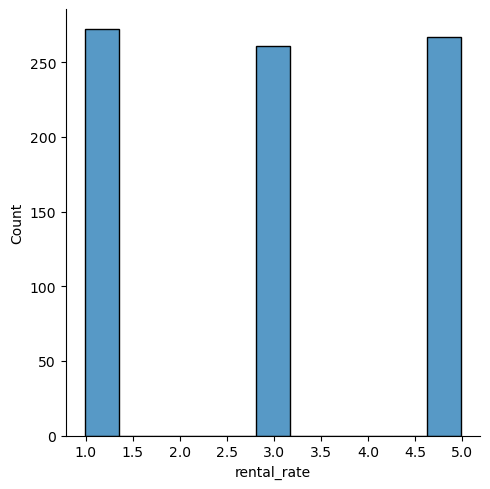

C:\Users\mburm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


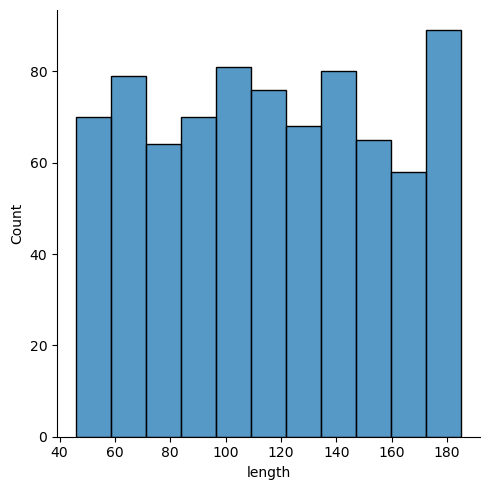

C:\Users\mburm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


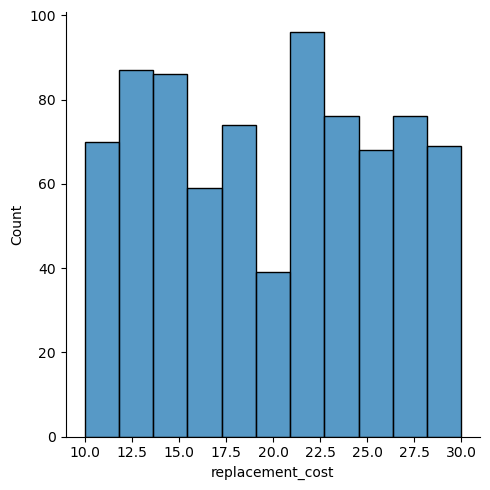

In [11]:
#Here we further analyze X_train
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(X_train_num['rental_rate'])
plt.show()

sns.displot(X_train_num['length'])
plt.show()

sns.displot(X_train_num['replacement_cost'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

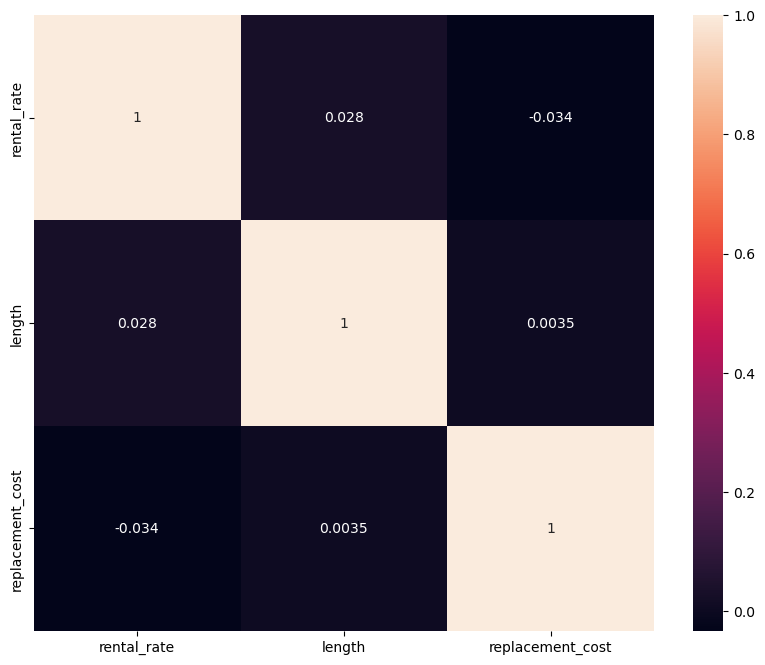

In [12]:
corr_matrix=X_train_num.select_dtypes(include=[np.number]).corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show

In [13]:
# Scaling data for train data

from sklearn.preprocessing import MinMaxScaler


transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_train_norm

,rental_rate,length,replacement_cost
0,1.0,0.294964,0.15
1,1.0,0.446043,0.20
2,0.0,0.510791,1.00
3,1.0,0.460432,0.30
4,0.5,0.525180,0.15
...,...,...,...
795,0.0,0.230216,0.95
796,0.0,0.043165,0.10
797,0.0,0.654676,0.40
798,0.0,0.100719,0.90


In [14]:
# Scaling data for test data

X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized, columns=X_test_num.columns)
X_test_norm

,rental_rate,length,replacement_cost
0,0.5,0.323741,0.95
1,1.0,0.474820,0.80
2,0.5,0.381295,0.75
3,0.5,0.532374,0.05
4,1.0,0.388489,0.05
...,...,...,...
195,1.0,0.733813,0.40
196,0.0,0.402878,0.15
197,0.5,0.172662,0.65
198,0.0,0.769784,0.55


In [15]:
#OneHotEncoding for train data

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first').fit(X_train_cat)
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
X_train_cat_encoded = pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns=cols)
X_train_cat_encoded

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
798,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#OneHotEncoding for test data

X_test_cat_encoded = pd.DataFrame(encoder.transform(X_test_cat).toarray(),columns=cols)
X_test_cat_encoded

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
196,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
198,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat_encoded], axis=1)

5) Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [18]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

6) Evaluate the results.

In [19]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat_encoded], axis=1)

In [20]:
predictions = classification.predict(X_test_transformed)
predictions


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [21]:
classification.score(X_test_transformed, y_test)

0.645

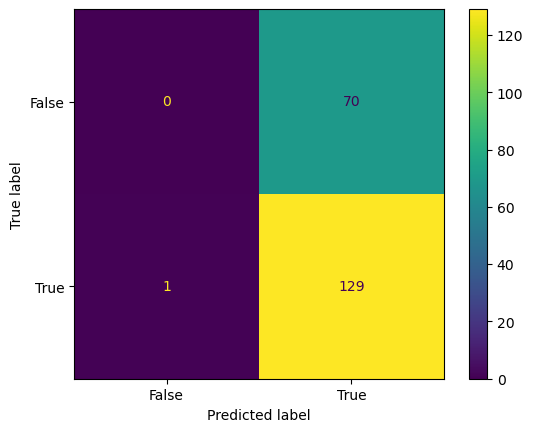

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification.classes_)
cm_display.plot()